In [1]:
import numpy as np
from abc import ABC, abstractmethod
from scipy import linalg
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array
from typing import List, Optional, Union

# ==============================================================================
# 1. Abstract Strategy (The Interface)
# ==============================================================================

class ContextualRisk(ABC):
    """
    Abstract base class for defining the 'Risk' in data selection.
    This allows TAAQ to plug-and-play different objectives (Efficiency vs Robustness).
    """
    @abstractmethod
    def compute_multiplier(
        self,
        M_residual: np.ndarray,
        r_target: Optional[np.ndarray],
        candidates: np.ndarray,
        selected_indices: List[int],
        context: Optional[np.ndarray]
    ) -> np.ndarray:
        """
        Computes the penalty multiplier in [0, 1]. 
        1.0 = Safe (Keep Score), 0.0 = Risky (Suppress).
        """
        pass

    def __repr__(self):
        return f"{self.__class__.__name__}()"

# ==============================================================================
# 2. Concrete Strategies (The Modules)
# ==============================================================================

class GeometricDiversityRisk(ContextualRisk):
    """
    Risk = Redundancy (Geometric Similarity).
    Used for: Efficiency tasks (Coreset, Token Selection).
    """
    def __init__(self, tau: float = 0.2, min_multiplier: float = 0.1):
        self.tau = tau
        self.min_multiplier = min_multiplier

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context=None):
        n_features = M_residual.shape[1]
        
        # Optimization: Return ones if diversity is disabled or no selection yet
        if not selected_indices or self.tau <= 0:
            return np.ones(n_features)
            
        active_idx = np.where(candidates)[0]
        if active_idx.size == 0:
            return np.ones(n_features)

        # Normalize vectors in the current residual space
        X_cand = M_residual[:, active_idx]
        X_sel = M_residual[:, selected_indices]
        
        nc = np.linalg.norm(X_cand, axis=0) + 1e-12
        ns = np.linalg.norm(X_sel, axis=0) + 1e-12
        
        X_cand_n = X_cand / nc
        X_sel_n = X_sel / ns
        
        # Compute Max Cosine Similarity
        # shape: (n_selected, n_candidates) -> max -> (n_candidates,)
        sim = np.abs(X_sel_n.T @ X_cand_n)
        max_sim = np.max(sim, axis=0)
        
        # Compute Penalty: 1 - tau * similarity
        penalties = np.clip(1.0 - self.tau * max_sim, self.min_multiplier, 1.0)
        
        out = np.ones(n_features)
        out[active_idx] = penalties
        return out

    def __repr__(self):
        return f"GeometricDiversityRisk(tau={self.tau})"


class InvariantCausalRisk(ContextualRisk):
    """
    Risk = Instability (Variance across Environments).
    Used for: Robustness tasks (OOD Feature Selection).
    """
    def __init__(self, lambda_var: float = 2.0, lambda_flip: float = 1.0, thr: float = 0.05, min_multiplier: float = 1e-3, var_weighting: str = "count"):
        self.lambda_var = lambda_var
        self.lambda_flip = lambda_flip
        self.thr = thr
        self.min_multiplier = min_multiplier
        self.var_weighting = var_weighting

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context):
        if context is None:
            raise ValueError("InvariantCausalRisk requires 'context' (environment IDs).")
        if r_target is None:
            raise ValueError("InvariantCausalRisk requires 'y' (target vector).")
            
        n_features = M_residual.shape[1]
        active_idx = np.where(candidates)[0]
        if active_idx.size == 0:
            return np.ones(n_features)
            
        eps = 1e-9
        Xa = M_residual[:, active_idx]
        
        # Handle environment statistics
        envs, counts = np.unique(context, return_counts=True)
        if envs.size < 2:
            # Cannot compute variance with < 2 environments
            return np.ones(n_features)
            
        corr_list, w_list = [], []
        for e, c in zip(envs, counts):
            mask = context == e
            if np.sum(mask) < 2: continue
                
            X_e = Xa[mask]
            y_e = r_target[mask]
            
            # Center and scale for correlation (slope) calculation
            y_e = y_e - y_e.mean()
            ny = np.linalg.norm(y_e) + eps
            
            X_e = X_e - X_e.mean(axis=0, keepdims=True)
            nx = np.linalg.norm(X_e, axis=0) + eps
            
            corr_e = (X_e.T @ y_e) / (nx * ny)
            corr_list.append(corr_e)
            w_list.append(float(c))
            
        if not corr_list:
            return np.ones(n_features)

        C = np.vstack(corr_list)
        
        # 1. Variance Risk (Weighted or Standard)
        if self.var_weighting == "count":
            w = np.asarray(w_list, dtype=float)
            w = w / (w.sum() + eps)
            mean = (w[:, None] * C).sum(axis=0)
            var_risk = (w[:, None] * (C - mean) ** 2).sum(axis=0)
        else:
            var_risk = np.var(C, axis=0)
        
        # 2. Sign-Flip Risk
        sig = np.abs(C) > self.thr
        has_pos = np.any((C > 0) & sig, axis=0)
        has_neg = np.any((C < 0) & sig, axis=0)
        flip_risk = (has_pos & has_neg).astype(float)
        
        # Total Penalty
        total_risk = self.lambda_var * var_risk + self.lambda_flip * flip_risk
        penalty = 1.0 / (1.0 + total_risk)
        
        penalty = np.clip(penalty, self.min_multiplier, 1.0)
        out = np.ones(n_features)
        out[active_idx] = penalty
        return out

    def __repr__(self):
        return f"InvariantCausalRisk(var={self.lambda_var}, flip={self.lambda_flip})"


class CompositeRisk(ContextualRisk):
    """
    Combines multiple risks (e.g., Efficiency + Robustness).
    """
    def __init__(self, risks: List[ContextualRisk], combine: str = "product", min_multiplier: float = 1e-3):
        self.risks = risks
        self.combine = combine
        self.min_multiplier = min_multiplier

    def compute_multiplier(self, M_residual, r_target, candidates, selected_indices, context):
        outs = [r.compute_multiplier(M_residual, r_target, candidates, selected_indices, context) for r in self.risks]
        
        if not outs:
            return np.ones(M_residual.shape[1])
            
        if self.combine == "product":
            m = np.prod(outs, axis=0)
        elif self.combine == "min":
            m = np.min(outs, axis=0)
        else: # average
            m = np.mean(outs, axis=0)
            
        return np.clip(m, self.min_multiplier, 1.0)

    def __repr__(self):
        return f"CompositeRisk(risks={self.risks})"


# ==============================================================================
# 3. The Unified Engine (TAAQ)
# ==============================================================================

class TAAQ(BaseEstimator, TransformerMixin):
    """
    The Unified Spectral Selection Engine.
    Delegates risk calculation to the injected 'risk_strategy'.
    """
    def __init__(self, k: int, risk_strategy: ContextualRisk, k1_ratio: float = 0.1, epsilon: float = 1e-9, verbose: bool = False):
        self.k = k
        self.risk_strategy = risk_strategy
        self.k1_ratio = k1_ratio
        self.epsilon = epsilon
        self.verbose = verbose
        self.selected_indices_ = None
        self.n_features_in_ = None

    def fit(self, X, y=None, context=None):
        """
        Fit the TAAQ model.
        """
        X = check_array(X)
        n_samples, n_features = X.shape
        
        if not (1 <= self.k <= n_features):
            raise ValueError(f"k must be in [1, n_features={n_features}].")
            
        self.n_features_in_ = n_features
        
        # Standardization (Required for Spectral Methods)
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0) + self.epsilon
        M = (X - X_mean) / X_std
        
        # Target Preprocessing
        r = None
        if y is not None:
            y = np.asarray(y, dtype=float)
            yc = y - y.mean()
            ny = np.linalg.norm(yc)
            if ny > self.epsilon:
                r = (yc / ny * np.sqrt(n_samples))
            else:
                r = yc
                
        # --- Phase 1: Spectral Gating (QRCP) ---
        k1 = int(self.k * self.k1_ratio)
        k1 = max(0, min(k1, n_features, self.k))
        S: List[int] = []
        
        if k1 > 0:
            Q, _, P = linalg.qr(M, mode="economic", pivoting=True)
            # Safety check for rank deficiency
            qcols = Q.shape[1]
            if qcols > 0:
                k1 = min(k1, qcols)
                S = list(P[:k1])
                Qg = Q[:, :k1]
                # Project out gated subspace
                M = M - Qg @ (Qg.T @ M)
                if r is not None:
                    r = r - Qg @ (Qg.T @ r)
            else:
                k1 = 0
        
        # --- Phase 2: Generalized Greedy Selection ---
        candidates = np.ones(n_features, dtype=bool)
        if S:
            candidates[S] = False
            
        while len(S) < self.k:
            # A. Compute Signal (Energy or Alignment)
            norms_sq = np.sum(M**2, axis=0)
            valid_mask = (norms_sq > self.epsilon) & candidates
            
            if not np.any(valid_mask):
                if self.verbose: print("Converged early: No more energy.")
                break
            
            if r is not None:
                # Supervised Alignment
                dots = M.T @ r
                signal = (dots**2) / (norms_sq + self.epsilon)
            else:
                # Unsupervised Energy
                signal = norms_sq
            
            # B. Compute Risk Multiplier (Strategy Call)
            mult = self.risk_strategy.compute_multiplier(M, r, valid_mask, S, context)
            
            # C. Selection
            scores = np.zeros(n_features)
            scores[valid_mask] = signal[valid_mask] * mult[valid_mask]
            
            best_idx = int(np.argmax(scores))
            S.append(best_idx)
            candidates[best_idx] = False
            
            # D. Residual Update (OMP Step)
            x = M[:, best_idx]
            nx = np.linalg.norm(x)
            
            if nx > self.epsilon:
                u = x / nx
                # M <- M - u u^T M
                proj = u @ M
                M = M - np.outer(u, proj)
                
                if r is not None:
                    r = r - (u @ r) * u
                    
        self.selected_indices_ = np.array(S, dtype=int)
        return self

    def transform(self, X):
        X = check_array(X)
        if self.selected_indices_ is None:
            raise ValueError("Model not fitted.")
        return X[:, self.selected_indices_]

    def get_support(self, indices: bool = False):
        if self.selected_indices_ is None:
            raise ValueError("Model not fitted.")
        if indices:
            return self.selected_indices_.copy()
        mask = np.zeros(self.n_features_in_, dtype=bool)
        mask[self.selected_indices_] = True
        return mask

    def fit_transform(self, X, y=None, context=None):
        self.fit(X, y=y, context=context)
        return self.transform(X)


# ==============================================================================
# 4. Factory Functions (User API)
# ==============================================================================

def TAAQ_Efficiency(k, k1_ratio=0.25, tau=0.2, min_multiplier=0.1):
    """Factory for Efficiency Mode (Geometric Diversity only)."""
    strategy = GeometricDiversityRisk(tau=tau, min_multiplier=min_multiplier)
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

def TAAQ_RobustnessPure(k, k1_ratio=0.0, lambda_var=10.0, lambda_flip=5.0, thr=0.05, min_multiplier=1e-4, var_weighting="count"):
    """
    Factory for Robustness Mode.
    """
    strategy = InvariantCausalRisk(
        lambda_var=lambda_var, 
        lambda_flip=lambda_flip, 
        thr=thr, 
        min_multiplier=min_multiplier, 
        var_weighting=var_weighting
    )
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

def TAAQ_Hybrid(k, k1_ratio=0.0, lambda_var=10.0, lambda_flip=5.0, thr=0.05, tau=0.2, min_multiplier=1e-4, var_weighting="count"):
    """
    Factory for Hybrid Mode..
    """
    strategy = CompositeRisk(
        [
            InvariantCausalRisk(lambda_var=lambda_var, lambda_flip=lambda_flip, thr=thr, min_multiplier=min_multiplier, var_weighting=var_weighting),
            GeometricDiversityRisk(tau=tau, min_multiplier=max(min_multiplier, 0.1)),
        ],
        combine="product",
        min_multiplier=min_multiplier,
    )
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)
    
def TAAQ_Universal(k, k1_ratio=0.1, lambda_var=2.0, lambda_flip=1.0, thr=0.05, tau=0.0, min_multiplier=1e-3, var_weighting="count"):
    """Factory for auto-configuring based on parameters."""
    risks = [InvariantCausalRisk(lambda_var=lambda_var, lambda_flip=lambda_flip, thr=thr, min_multiplier=min_multiplier, var_weighting=var_weighting)]
    if tau > 0:
        risks.append(GeometricDiversityRisk(tau=tau, min_multiplier=max(min_multiplier, 0.1)))
        strategy = CompositeRisk(risks, combine="product", min_multiplier=min_multiplier)
    else:
        strategy = risks[0]
    return TAAQ(k=k, risk_strategy=strategy, k1_ratio=k1_ratio)

Computing full train set embeddings...
Loading cached embeddings from ./cache/cifar100_train_resnet18.npz
Computing test set embeddings...
Loading cached embeddings from ./cache/cifar100_test_resnet18.npz
Experiment finished, results saved to cache.


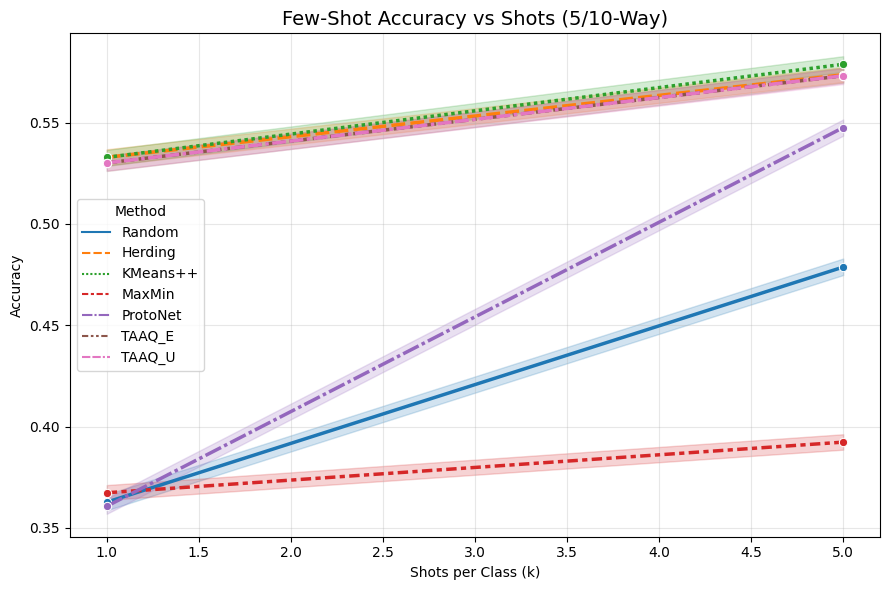

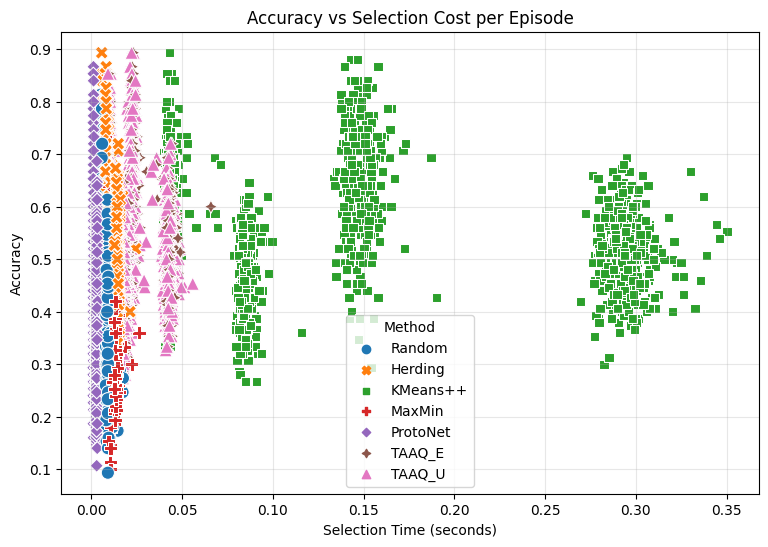


[Few-Shot Accuracy vs Shots Summary]
Shots         1      5
Method                
Herding   0.533  0.574
KMeans++  0.533  0.579
MaxMin    0.367  0.392
ProtoNet  0.361  0.548
Random    0.363  0.479
TAAQ_E    0.530  0.573
TAAQ_U    0.530  0.573

[Few-Shot Accuracy vs Time Summary]
Shots         1      5
Method                
Herding   0.008  0.011
KMeans++  0.064  0.221
MaxMin    0.008  0.010
ProtoNet  0.002  0.002
Random    0.007  0.007
TAAQ_E    0.014  0.033
TAAQ_U    0.014  0.033


In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import os

warnings.filterwarnings("ignore")
SELECTION_SUBSET_SIZE = 10000
BATCH_SIZE = 128
APPLY_PCA = False
PCA_DIM = 256

# ======================================================================
# Load CIFAR-100
# ======================================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Subset of training set (to speed up selection)
rng = np.random.default_rng(42)
subset_indices = rng.choice(len(trainset), SELECTION_SUBSET_SIZE, replace=False)
train_subset = Subset(trainset, subset_indices)

train_loader_all = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
train_loader_subset = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# ==============================================================================
# Backbone - ResNet-18
# ==============================================================================
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  # remove classification layer (B, 512, 1, 1)
resnet18.eval()
resnet18.cuda()

# Compute embeddings
def extract_embeddings(dataloader, model, cache_path=None, max_items=None):
    """
    Extract embeddings for all images in dataloader using `model`.
    If cache_path exists, load and return cached arrays.
    Returns X (n_samples, feat_dim), y (n_samples,)
    """    
    if cache_path and os.path.exists(cache_path):
        print(f"Loading cached embeddings from {cache_path}")
        d = np.load(cache_path)
        return d["X"], d["y"]
        
    embeddings = []
    labels = []
    with torch.no_grad():
        for imgs, label in tqdm(dataloader, desc="Embedding"):
            imgs = imgs.cuda()
            feats = model(imgs)
            feats = feats.reshape(feats.size(0), -1).cpu().numpy()
            embeddings.append(feats)
            labels.append(label.numpy())
            if max_items and sum(len(a) for a in embeddings) >= max_items:
                break
    X = np.concatenate(embeddings, axis=0)[:max_items] if max_items else np.concatenate(embeddings, axis=0)
    y = np.concatenate(labels, axis=0)[:len(X)]

    if cache_path:
        np.savez_compressed(cache_path, X=X, y=y)
        print(f"Saved cache to {cache_path}")
    
    return X, y


# ======================================================================
# Compute embeddings
# ======================================================================
os.makedirs("./cache", exist_ok=True)
train_cache = os.path.join("./cache", "cifar100_train_resnet18.npz")
test_cache = os.path.join("./cache", "cifar100_test_resnet18.npz")

print("Computing full train set embeddings...")
X_train_embed, y_train = extract_embeddings(train_loader_all, resnet18, cache_path=train_cache)
print("Computing test set embeddings...")
X_test_embed, y_test = extract_embeddings(test_loader, resnet18, cache_path=test_cache)

if APPLY_PCA:
    print(f"Applying PCA -> {PCA_DIM} dims")
    pca = PCA(n_components=PCA_DIM)
    X_train_pca = pca.fit_transform(X_train_embed)
    X_test_pca = pca.transform(X_test_embed)
    X_train = X_train_pca
    X_test = X_test_pca
else:
    X_train = X_train_embed
    X_test = X_test_embed

X_train_subset = X_train[subset_indices]
y_train_subset = y_train[subset_indices]


# ======================================================================
# Baseline Selection Methods
# ======================================================================
# HERDING
def herding_selection(X, k):
    mu = np.mean(X, axis=0)
    selected = []
    cur_sum = np.zeros_like(mu)
    mask = np.ones(len(X), dtype=bool)

    for t in range(1, k + 1):
        tgt = t * mu - cur_sum
        idxs = np.where(mask)[0]
        dists = np.linalg.norm(X[idxs] - tgt, axis=1)
        best = idxs[np.argmin(dists)]
        selected.append(best)
        cur_sum += X[best]
        mask[best] = False

    return np.array(selected)


# K-MEANS++
def kmeans_pp_selection(X, k, seed=0):
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=seed).fit(X)
    selected = []
    for center in km.cluster_centers_:
        d = np.linalg.norm(X - center, axis=1)
        selected.append(int(np.argmin(d)))
    return np.array(selected)


#MAX-MIN DIVERSITY  
def max_min_diversity(X, k, seed=0):
    rng = np.random.default_rng(seed)
    first = rng.integers(0, len(X))
    selected = [first]
    min_d = np.linalg.norm(X - X[first], axis=1)

    for _ in range(1, k):
        nxt = int(np.argmax(min_d))
        selected.append(nxt)
        new_d = np.linalg.norm(X - X[nxt], axis=1)
        min_d = np.minimum(min_d, new_d)

    return np.array(selected)

# ======================================================================
# ProtoNet: compute class prototypes
# ======================================================================
def prototypical_accuracy(X_support, y_support, X_query, y_query):
    classes = np.unique(y_support)
    prototypes = np.stack([X_support[y_support==c].mean(axis=0) for c in classes])
    dists = ((X_query[:,None,:] - prototypes[None,:,:])**2).sum(axis=2)
    y_pred = classes[np.argmin(dists, axis=1)]
    return accuracy_score(y_query, y_pred)


# ======================================================================
# TAAQ efficient
# ======================================================================
def run_taaq_efficient(X, k, target_vec=None):
    """
    X: (n_pool, d)
    """
    if target_vec is None:
        target_vec = X.mean(axis=0)
        
    selector = TAAQ_Efficiency(k=k, k1_ratio=0.0, tau=0.1)
    selector.fit(X.T, y=target_vec)
    return selector.selected_indices_


# ======================================================================
# TAAQ universal
# ======================================================================
def run_taaq_universal(X_pool, k, target_vec=None, domain_labels=None):
    n = len(X_pool)

    if domain_labels is None:
        return run_taaq_efficient(X_pool, k, target_vec)

    # Build domain
    domains = np.unique(domain_labels)
    domain_centers = {}

    for d in domains:
        domain_centers[d] = X_pool[domain_labels == d].mean(axis=0)

    # Compute domain-aware utility score
    scores = np.zeros(n)
    for i in range(n):
        x = X_pool[i]
        d = domain_labels[i]

        # Similarity to domain center
        dom_sim = np.dot(x, domain_centers[d])

        # Similarity to global target (if given)
        tgt_sim = 0 if target_vec is None else np.dot(x, target_vec)

        scores[i] = dom_sim + tgt_sim

    # Select top-k by combined score
    chosen = np.argsort(scores)[-k:]
    return chosen


# ======================================================================
# Few-shot episodic sampling
# ======================================================================
def sample_episode(y, N_way, K_shot, Q_query, rng):
    classes = rng.choice(np.unique(y), size=N_way, replace=False)
    support_idx, query_idx = [], []
    for c in classes:
        idx = np.where(y==c)[0].copy()
        rng.shuffle(idx)
        support_idx.extend(idx[:K_shot])
        query_idx.extend(idx[K_shot:K_shot+Q_query])
    return np.array(support_idx), np.array(query_idx), classes


# ======================================================================
# Experiment
# ======================================================================
def run_fewshot_experiment(X_emb, y, X_idx, domain_labels_emb=None, N_way_list=[5,10], shots=[1,5], q_query=15, episodes_per_seed=200, seeds=[0,1]):
    """
    X_emb, y: full training embeddings and labels (numpy arrays)
    X_pool_indices: indices into X_emb (the selection pools — our subset)
    """
    results = [] 
    for N_way in N_way_list:
        for seed in seeds:
            rng = np.random.default_rng(seed)
            for k_shot in shots:
                for ep in range(episodes_per_seed):
                    # Sample episode (classes chosen from overall label set)
                    support_idx, query_idx, episode_classes = sample_episode(y, N_way, k_shot, q_query, rng)
                    # Create pools for each class drawn from the subset indices
                    support_pools = {c: X_idx[np.where(y[X_idx] == c)[0]] for c in episode_classes}
                    
                    # If any class has insufficient pool size, skip this episode
                    skip = False
                    for c in episode_classes:
                        if len(support_pools[c]) < k_shot + q_query:
                            skip = True
                            break
                    if skip:
                        continue

                    # query: sample queries from the global train (or test) for evaluation
                    # Sample queries from y and pick queries from the whole set but only from episode_classes
                    query_idx = []
                    for c in episode_classes:
                        idxs = np.where(y == c)[0]
                        rng.shuffle(idxs)
                        query_idx.extend(idxs[k_shot:k_shot+q_query])
                    query_idx = np.array(query_idx)
                    X_q = X_emb[query_idx]
                    y_q = y[query_idx]
                    
                    for method in ["Random","Herding","KMeans++","MaxMin","ProtoNet","TAAQ_E", "TAAQ_U"]:
                        start_time = time.time()
                        sup_indices = []
                        for c in episode_classes:
                            pool_idx = support_pools[c]
                            X_pool = X_emb[pool_idx]

                            # Domain labels subset
                            domain_labels_pool = None
                            if domain_labels_emb is not None:
                                domain_labels_pool = domain_labels_emb[pool_idx]                           
                            
                            if method=="Random":
                                chosen = rng.choice(len(X_pool), k_shot, replace=False)
                            elif method=="Herding":
                                chosen = herding_selection(X_pool, k_shot)
                            elif method=="KMeans++":
                                chosen = kmeans_pp_selection(X_pool, k_shot, seed)
                            elif method=="MaxMin":
                                chosen = max_min_diversity(X_pool, k_shot, seed)
                            elif method=="ProtoNet":
                                chosen = np.arange(k_shot)
                            elif method=="TAAQ_E":
                                chosen = run_taaq_efficient(X_pool, k_shot, target_vec=None)
                            elif method=="TAAQ_U":
                                chosen = run_taaq_universal(X_pool, k_shot,target_vec=None, domain_labels=domain_labels_pool)                  
                            else:
                                raise ValueError(f"Unknown method {method}")
                            sup_indices.extend(pool_idx[chosen])

                        # Accuracy
                        if method=="ProtoNet":
                            acc = prototypical_accuracy(X_emb[sup_indices], y[sup_indices], X_q, y_q)
                        else:
                            clf = KNeighborsClassifier(n_neighbors=1)
                            clf.fit(X_emb[sup_indices], y[sup_indices])
                            acc = clf.score(X_q, y_q)
    
                        elapsed_time = time.time() - start_time

                        results.append({
                            "Method": method,
                            "Shots": k_shot,
                            "N_way": N_way,
                            "Accuracy": acc,
                            "ElapsedTime": elapsed_time
                        })
    return pd.DataFrame(results)

df = run_fewshot_experiment(X_train, y_train, subset_indices, N_way_list=[5,10], shots=[1,5], episodes_per_seed=200, seeds=[0,1])
df.to_csv(os.path.join("./cache", "fewshot_results.csv"), index=False)
print("Experiment finished, results saved to cache.")


# ======================================================================
# Plots and Summary
# ======================================================================
#Accuracy (with CI) vs Shots
plt.figure(figsize=(9,6))
sns.lineplot(
    data=df,
    x="Shots",
    y="Accuracy",
    hue="Method",
    style="Method",
    marker="o",
    # ci="sd",
    # err_style="bars",
    # errorbar=("sd")  # or "se"
    ci=68,
    linewidth=2.5
)
plt.title("Few-Shot Accuracy vs Shots (5/10-Way)", fontsize=14)
plt.xlabel("Shots per Class (k)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Annotate TAAQ_Universal 
# try:
#     taa_df = df[df["Method"]=="TAAQ_U"].groupby("Shots")["Accuracy"].mean()
#     x_val = 1
#     y_val = taa_df.loc[x_val]
#     plt.annotate(
#         "TAAQ-Universal Performance",
#         xy=(x_val, y_val),
#         xytext=(x_val + 0.5, y_val + 0.05),
#         arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
#         fontsize=11,
#         color="black"
#     )
# except Exception:
#     pass

# # Annotate TAAQ_Efficient
# try:
#     taa_df = df[df["Method"]=="TAAQ_E"].groupby("Shots")["Accuracy"].mean()
#     x_val = 1
#     y_val = taa_df.loc[x_val]
#     plt.annotate(
#         "TAAQ-Efficient Performance",
#         xy=(x_val, y_val),
#         xytext=(x_val + 0.5, y_val + 0.05),
#         arrowprops=dict(facecolor="black", arrowstyle="->", lw=1.5),
#         fontsize=11,
#         color="black"
#     )
# except Exception:
#     pass

plt.tight_layout()
plt.show()


# Total Time vs Shots
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=df,
    x="ElapsedTime",
    y="Accuracy",
    hue="Method",
    style="Method",
    s=90
)
plt.title("Accuracy vs Selection Cost per Episode")
plt.xlabel("Selection Time (seconds)")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.show()

# plt.figure(figsize=(9, 6))
# sns.lineplot(
#     data=df,
#     x="ElapsedTime",
#     y="Accuracy",
#     hue="Method",
#     style="Method",
#     marker="o",
#     # ci="sd",
#     # err_style="bars",
#     # errorbar=("sd")  # or "se"
#     linewidth=2.5
# )

# plt.title(
#     "Few-Shot Selection: Time vs Shots per Class",
#     fontsize=14,
# )
# plt.ylabel("Time (seconds)", fontsize=12)
# plt.xlabel("Shots per Class (k)", fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.xticks(sorted(df["Shots"].unique()))

# plt.tight_layout()
# plt.show()

# Summary 
print("\n[Few-Shot Accuracy vs Shots Summary]")
print(
    df.groupby(["Method", "Shots"])["Accuracy"]
    .mean()
    .unstack()
    .round(3)
)

print("\n[Few-Shot Accuracy vs Time Summary]")
print(
    df.groupby(["Method", "Shots"])["ElapsedTime"]
    .mean()
    .unstack()
    .round(3)
)